<img src="https://www.th-koeln.de/img/logo.svg" style="float: right;" width="200" alt="Th-Köln-Logo">

# DIS21a 1 | Big Data | Exam WS 2022/23 | Group J (10)

## Participants

-   [Markus Hardtke](https://elearning.iws.th-koeln.de/moodle/user/profile.php?id=2705)
    -   Matriculation Number: 1234567
-   [Furkan Erdogan](https://elearning.iws.th-koeln.de/moodle/user/profile.php?id=2688)
    -   Matriculation Number: 11136112
-   [Jannik Loose](https://elearning.iws.th-koeln.de/moodle/user/profile.php?id=2687)
    -   Matriculation Number: 1234567
-   [Gilles Romer](https://elearning.iws.th-koeln.de/moodle/user/profile.php?id=2681)
    -   Matriculation Number: 11139919

---

## Project Setup

*This Setup was made for Windows users and will differ if you are using a different OS.    
The recommended Python version used to run this notebook is 3.9.13*

1. Virtual environment

    *This step is required so you can install the required packages without affecting or filling up your global Python installation.*

    ```bash
    python3 -m venv .venv
    source .venv/Scripts/activate
    pip install -r requirements.txt
    ```

2. Git

    *This step is required so unnecessary data from the Notebook is not pushed to the repository. This will automatically remove all metadata and execution counts from the Notebook as soon as you stage your file.*

    1. Download JQ (flexible command-line JSON processor) from [here](https://github.com/stedolan/jq/releases/download/jq-1.6/jq-win64.exe)
    2. Create the following Folder: `C:\Program Files\jq`
    3. Add the following line to your PATH environment variable: `C:\Program Files\jq`
    4. Rename the downloaded JQ file to `jq.exe` and move it to the previously created folder
    5. Add the following lines to your .gitconfig file (usually found in C:\Users\YOUR_USERNAME\.gitconfig)

        ```bash
        [core]
            attributesfile = ~/.gitattributes_global
        [filter "nbstrip_meta"]
            clean = "jq --indent 4 \
                    '(.cells[] | select(has(\"execution_count\")) | .execution_count) = null  \
                    | .metadata = {\"language_info\": {\"name\": \"python\", \"pygments_lexer\": \"ipython3\"}} \
                    | .cells[].metadata = {} \
                    '"
            smudge = cat
            required = true
        [filter "nbstrip_full"]
            clean = "jq --indent 4 \
                    '(.cells[] | select(has(\"outputs\")) | .outputs) = []  \
                    | (.cells[] | select(has(\"execution_count\")) | .execution_count) = null  \
                    | .metadata = {\"language_info\": {\"name\": \"python\", \"pygments_lexer\": \"ipython3\"}} \
                    | .cells[].metadata = {} \
                    '"
            smudge = cat
            required = true
        ```

    6. Create a `.gitattributes_global` file at the same location as your `.gitconfig` file and add the following lines:

        ```bash
        *.ipynb filter=nbstrip_meta
        ```

3. Weights and Biases

    *Weights and Biases is a tool that helps you track your experiments and visualize your results. It is also used to run hyperparameter sweeps.*  
    
    Make sure to create an account on [Weights and Biases](https://wandb.ai/site) and accept the invitation to the Team.  
    Furthermore you will have to add your [API key](https://wandb.ai/settings#dangerzone) to the [scrts.py](./scrts.py) file under `wandb_api_key`.

## Optional Setup

1. Tensorflow GPU support  

    *<span style="color:orange">This step is optional and only required if you want to use a GPU for training.</span>*  
   Follow this setup to activate tensorflow GPU support (Make sure to install the mentioned versions rather than the latest one!): [https://www.tensorflow.org/install/gpu](https://www.tensorflow.org/install/gpu)  
   This tutorial will additionally help you to install CUDA and cuDNN: [https://lifewithdata.com/2022/01/16/how-to-install-tensorflow-and-keras-with-gpu-support-on-windows/](https://lifewithdata.com/2022/01/16/how-to-install-tensorflow-and-keras-with-gpu-support-on-windows/) 

---


## Objective

The aim of this kernel is to predict <span style="color:orange">partitions of images of different environments</span> from the dataset `environments` which are `{streets, sea, mountain, glacier, forest, buildings}`. We developed a classifier that distinguishes the images in the best possible way. The biggest challenge is to get the most accuracy with using our own image classification algorithm `categorical_classification` and trying out `ResNET` as an another image classification algorithm.

## Environment Setup

### Path's

We're importing libraries `os` and `sys`. 
The os and sys modules provide numerous tools for dealing with file names, paths and directories. We're setting up the path to the root of our repository.


In [ ]:
# Importing the necessary libraries
import os
import sys

# Setting up the path to the root of the repository
path = os.getcwd()
notebookpath = os.path.join(path, 'Exam_WS2223.ipynb')

datapath = os.path.join(path, 'data')
data_testpath = os.path.join(datapath, 'seg_test')
data_trainpath = os.path.join(datapath, 'seg_train')
data_valpath = os.path.join(datapath, 'seg_pred')

### Tensorflow version and GPU availability

We're importing here important and necessary libraries. Then we're checking with the code the versions and gpu availability to set up the GPU if it was installed in the section above. This code then will tell if the GPU is available or not in case if one should have overlooked a step.


In [ ]:
# Importing the libraries
import tensorflow as tf
from tensorflow import keras
import gc

# Checking versions and gpu availability
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# Setting up the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


Tensorflow version: 2.10.0
Keras Version: 2.10.0
GPU is available
1 Physical GPUs, 1 Logical GPUs


### Wandb

Here we import more important libraries to remove unnecessary logs later.  
**WandbMetricsLogger: Used for Experiment Tracking.  
WandbModelCheckpoints: Used to log the model checkpoints to Weight and Biases Artifacts.**

In [ ]:
# Importing the libraries
import wandb
import scrts
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import logging
import absl.logging
import os

# Removing all unnecessary logs
absl.logging.set_verbosity(absl.logging.ERROR)
logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
os.environ['WANDB_SILENT'] = 'true'
os.environ['WANDB_CONSOLE'] = 'off'
os.environ['WANDB_NOTEBOOK_NAME'] = notebookpath
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

if scrts.wandb_api_key is None:
    print("Please enter your wandb API key in scrts.py")
else:
    wandb.login(key=scrts.wandb_api_key)

---
## Helper functions

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting the loss and accuracy of the model
def plot_loss_accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(history.history["loss"], label="Training loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(history.history["accuracy"], label="Training accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation accuracy")
    plt.legend()
    plt.show()

# Data loading and preprocessing (... a bit)
import random
import numpy as np
classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

from PIL import Image
from PIL.ExifTags import TAGS
def load_data(datapath, classes):
    # Only load training and test data
    for dataset in os.listdir(datapath):
        if dataset == "seg_train" or dataset == "seg_test":
            # Load the data
            data = []
            for folder in os.listdir(os.path.join(datapath, dataset)):
                for image in os.listdir(os.path.join(datapath, dataset, folder)):
                    # resize images to 150x150
                    img = Image.open(os.path.join(datapath, dataset, folder, image))
                    img = img.resize((150, 150))
                    data.append([img, folder])
            # Shuffle the data
            random.shuffle(data)
            # Split the images into data(the actual image) and labels
            images = []
            labels = []
            for image in data:
                images.append(image[0])
                labels.append(image[1])
            if dataset == "seg_train":
                train_images = images
                train_labels = labels
            else:
                test_images = images
                test_labels = labels
    return train_images, train_labels, test_images, test_labels

# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def augment_data(datapath, classes, train_dir=data_trainpath, test_dir=data_testpath):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')
    return train_generator, test_generator

# Vectorizing the labels
def label_vectorization(labels):
    # Convert the labels to numbers
    for i, label in enumerate(labels):
        labels[i] = classes.index(label)
    # One-hot encoding the labels
    from tensorflow.keras.utils import to_categorical
    labels = to_categorical(labels, num_classes=len(classes))
    return labels

# Normalizing the images
def image_normalization(data):
    # Convert the images to arrays
    for i, image in enumerate(data):
        data[i] = np.array(image, dtype="float32")
    # Normalize the images
    data = np.array(data) / 255
    return data

def get_optimizer(lr=1e-3, optimizer="adam"):
    "Select optmizer between adam and rmsprop"
    if optimizer.lower() == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    if optimizer.lower() == "rmsprop":
        return tf.keras.optimizers.RMSprop(learning_rate=lr)

---
## What are we working with?

### What does the data look like?

This section is focused around training the data and to check if the training images have the same dimensions. For this purpose, a code was written that performs these steps for us and prints it out. If not, then it would print `The train/test image from the folder/image has different dimensions than the others`. Else, it will print `The training/testing data contains "amount" images with the dimensions "data_train_imgsize_height"x"data_train_imgsize_width".`

This also applies to the validation part of this code.



In [ ]:
# Show metadata of images and folders

# Training data
data_train_length = sum([len(files) for r, d, files in os.walk(data_trainpath)])
# Check if all training images have the same dimensions
for folder in os.listdir(data_trainpath):
    for i, image in enumerate(os.listdir(os.path.join(data_trainpath, folder))):
        if i == 0:
            data_train_imgsize_heigt = Image.open(os.path.join(data_trainpath, folder, image)).height
            data_train_imgsize_width = Image.open(os.path.join(data_trainpath, folder, image)).width
        else:
            if data_train_imgsize_heigt != Image.open(os.path.join(data_trainpath, folder, image)).height or data_train_imgsize_width != Image.open(os.path.join(data_trainpath, folder, image)).width:
                print(f"The train image {folder}/{image} has different dimensions than the others")
                break
print(f"The training data contains {sum([len(files) for r, d, files in os.walk(data_trainpath)])} images with the dimensions {data_train_imgsize_heigt}x{data_train_imgsize_width} pixels")

# Test data
data_val_length = sum([len(files) for r, d, files in os.walk(data_valpath)])
# Check if all test images have the same dimensions
for folder in os.listdir(data_testpath):
    for i, image in enumerate(os.listdir(os.path.join(data_testpath, folder))):
        if i == 0:
            data_test_imgsize_heigt = Image.open(os.path.join(data_testpath, folder, image)).height
            data_test_imgsize_width = Image.open(os.path.join(data_testpath, folder, image)).width
        else:
            if data_test_imgsize_heigt != Image.open(os.path.join(data_testpath, folder, image)).height or data_test_imgsize_width != Image.open(os.path.join(data_testpath, folder, image)).width:
                print(f"The test image {folder}/{image} has different dimensions than the others")
                break
print(f"The test data contains {sum([len(files) for r, d, files in os.walk(data_testpath)])} images with the dimensions {data_test_imgsize_heigt}x{data_test_imgsize_width} pixels")

# Validation data
data_val_length = sum([len(files) for r, d, files in os.walk(data_valpath)])
# Check if all validation images have the same dimensions
for i, image in enumerate(os.listdir(data_valpath)):
    if i == 0:
        data_val_imgsize_heigt = Image.open(os.path.join(data_valpath, image)).height
        data_val_imgsize_width = Image.open(os.path.join(data_valpath, image)).width
    else:
        if data_val_imgsize_heigt != Image.open(os.path.join(data_valpath, image)) or data_val_imgsize_width != Image.open(os.path.join(data_valpath, image)):
            print(f"The validation image {image} has different dimensions than the others")
            break
print(f"The validation data contains {sum([len(files) for r, d, files in os.walk(data_valpath)])} images with the dimensions {data_val_imgsize_heigt}x{data_val_imgsize_width} pixels")

The train image buildings/5358.jpg has different dimensions than the others
The train image forest/1004.jpg has different dimensions than the others
The train image glacier/1010.jpg has different dimensions than the others
The train image mountain/11873.jpg has different dimensions than the others
The train image sea/19551.jpg has different dimensions than the others
The train image street/13747.jpg has different dimensions than the others
The training data contains 14034 images with the dimensions 150x150 pixels
The test image forest/22014.jpg has different dimensions than the others
The test image glacier/21274.jpg has different dimensions than the others
The test image mountain/22117.jpg has different dimensions than the others
The test data contains 3000 images with the dimensions 150x150 pixels
The validation image 10005.jpg has different dimensions than the others
The validation data contains 7301 images with the dimensions 150x150 pixels


General image size = 150x150

### Loading and augmenting the data

Here we import the libraries `random` and `numpy` and try to load the dataset with the training data and testing data.

We then load the images and shuffle the images, which are then split into data and labels with a defined function.

In [ ]:
train_images, train_labels, test_images, test_labels = load_data(datapath, classes)

In [ ]:
train_generator, test_generator = augment_data(datapath, classes)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### Normalizing the data

Here we're vectorizing the labels and doing an [One-hot encoding the labels](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical). One-Hot Encoding is a popular technique for treating categorical variables. It simply creates additional features based on the number of unique values in the categorical feature. Every unique value in the category will be added as a feature.

We then normalized the images and converted them to arrays.

The main purpose of this process is to bring the transformation so that all the features work on the same or similar level of scale.

In [ ]:
train_labels = label_vectorization(train_labels)
test_labels = label_vectorization(test_labels)

train_images = image_normalization(train_images)
test_images = image_normalization(test_images)

### Checking dataset structure again

In this section we're checking the dimensions of the data again to make secure everything has worked so far. Then we import `matplotlib` and `seaborn` as libraries to show training and test data count for each class.

Then we're visualizing the propotion each class which is it in the training and test data in a pie chart.
We also show 5 random images in another 

The training data contains 14034 images with the dimensions (150, 150, 3) pixels
The test data contains 3000 images with the dimensions (150, 150, 3) pixels


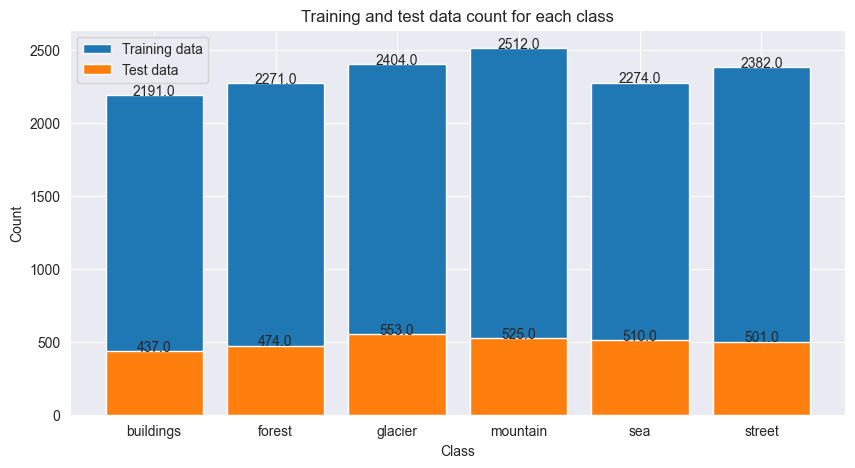

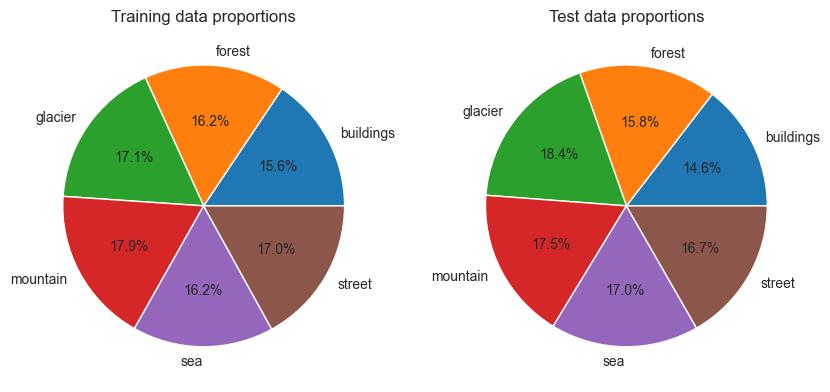

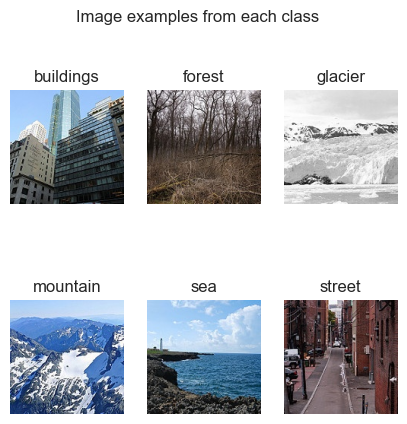

In [ ]:
# Checking the dimensions of the data
print(f"The training data contains {len(train_images)} images with the dimensions {train_images[0].shape} pixels")
print(f"The test data contains {len(test_images)} images with the dimensions {test_images[0].shape} pixels")

# Showing training and test data count for each class
sns.set_style("darkgrid")
plt.figure(figsize=(10, 5))
plt.title("Training and test data count for each class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.bar(classes, [train_labels[:, i].sum() for i in range(len(classes))], label="Training data")
plt.bar(classes, [test_labels[:, i].sum() for i in range(len(classes))], label="Test data")
for i in range(len(classes)):
    plt.text(x=classes[i], y=train_labels[:, i].sum(), s=train_labels[:, i].sum(), ha="center")
    plt.text(x=classes[i], y=test_labels[:, i].sum(), s=test_labels[:, i].sum(), ha="center")
plt.legend()
plt.show()

# Showing the proportion each class has in the training and test data in a pie chart
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Training data proportions")
plt.pie([train_labels[:, i].sum() for i in range(len(classes))], labels=classes, autopct="%1.1f%%")
plt.subplot(1, 2, 2)
plt.title("Test data proportions")
plt.pie([test_labels[:, i].sum() for i in range(len(classes))], labels=classes, autopct="%1.1f%%")
plt.show()

# Showing 5 random images from each class
plt.figure(figsize=(5, 5))
plt.suptitle("Image examples from each class")
for i in range(len(classes)):
    plt.subplot(2, 3, i + 1)
    plt.title(classes[i])
    plt.axis("off")
    plt.imshow(train_images[np.random.choice(np.where(train_labels[:, i] == 1)[0])])
plt.show()

---
## Building the model

Each Keras model is created using either the `Sequential` class, which is a linear stack of layers, or the Model functional class, which is more customizable. We're going to import Keras, obviously, but then also specifically the Sequential model type, `dense` layers, `dropout`, and `flatten` (to flatten the data before passing through the final, regular dense layer). Finally, we're using a convolutional neural network, so we're going to use `Conv2D` and `MaxPooling2D` for that.  Later in the code we train the model by defining a function with `batch_size`, `epochs` and `log_freq=10`.  At the end we fit the model and output `history`.

### Plain classification model

In [ ]:
# WandB configuration for the plain model
sweep_config = {
        'method': 'bayes',
        'metric': {
                'name': 'val_acc',
                'goal': 'maximize'
        },
        'parameters': {
                'epochs': {
                        'value': 20
                },
                'batch_size': {
                        'values': [32, 64, 128]
                },
                'dropout': {
                        'values': [0.4, 0.5, 0.6]
                },
                'optimizer': {
                        'values': ['adam', 'rmsprop']
                },
                'learning_rate': {
                        'values': [0.001, 0.002, 0.0005]
                }
        }
}

In [ ]:
# Importing the necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# model builder
def build_model(dropout, optimizer, lr, layers=[32, 64, 128, 128], input_shape=(150, 150, 3)):
    tf.keras.backend.clear_session()
    gc.collect()
    model = Sequential()

    for i, layer in enumerate(layers):
        if i == 0:
            model.add(Conv2D(layer, (3, 3), activation="relu", input_shape=input_shape))
            model.add(MaxPooling2D((2, 2)))
        else:
            model.add(Conv2D(layer, (3, 3), activation="relu"))
            model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(len(classes), activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer=get_optimizer(lr, optimizer), metrics=["accuracy"])

    return model

def fit_model(model, epochs, batch_size, log_freq=10, train_images=train_images, train_labels=train_labels, test_images=test_images, test_labels=test_labels, WandB_run=False):
    if WandB_run:
        history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels), verbose=0, callbacks=[WandbMetricsLogger(log_freq=log_freq)])
    else:
        history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels), verbose=0)
    return history

#### WandB run for auto logging

In [ ]:
def sweep_train(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(project="Exam", entity="dis21a1_ws22-21_gruppe10", config=config_defaults):  # this gets over-written in the Sweep

        # Specify the other hyperparameters to the configuration, if any
        wandb.config.architecture_name = "Plain CNN"
        wandb.config.dataset_name = "data"

        # initialize model
        model = build_model(
            wandb.config.dropout,
            wandb.config.optimizer,
            wandb.config.learning_rate
        )

        fit_model(
            model,
            wandb.config.epochs,
            wandb.config.batch_size
        )

sweep_id = wandb.sweep(sweep_config, project="Exam", entity="dis21a1_ws22-21_gruppe10")
wandb.agent(sweep_id, function=sweep_train, count=10)

Create sweep with ID: 6e0dfjfb
Sweep URL: https://wandb.ai/dis21a1_ws22-21_gruppe10/Exam/sweeps/6e0dfjfb


#### Manual run for evaluation

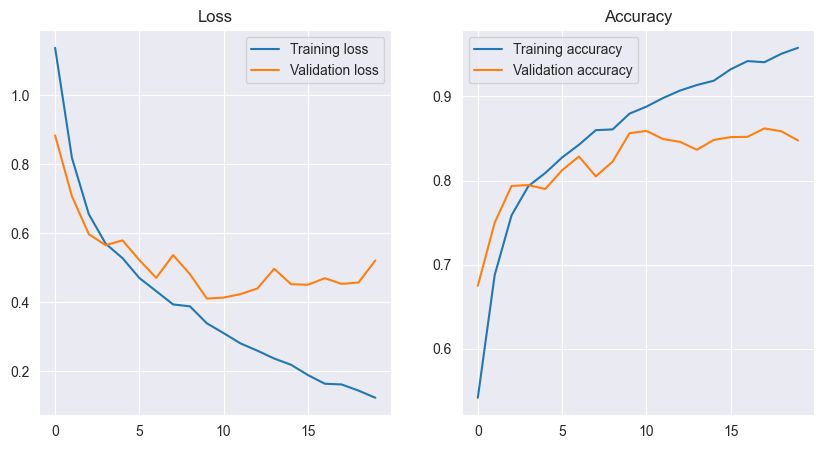

94/94 [==============================] - 1s 8ms/step - loss: 0.5204 - accuracy: 0.8477


In [ ]:
# model training
plain_model = build_model(0.5, "adam", 0.0005)
# plotting the loss and accuracy of the model
plot_loss_accuracy(fit_model(plain_model, 20, 128))
# Evaluating the model
plain_test_loss, plain_test_accuracy = plain_model.evaluate(test_images, test_labels)

In [ ]:
import pandas as pd
import tabulate

# Showing the WandB results in a table
# Reading in csv file
df = pd.read_csv("./wandb_export_Plain_CNN.csv")
# Sorting the results by validation accuracy
df = df.sort_values(by="epoch/val_accuracy", ascending=False)
# Showing the results in a fancy grid
print(tabulate.tabulate(df, headers="keys", tablefmt="fancy_grid", showindex=False))

╒═══════════╤══════════════╤═══════════╤═════════════════╤═════════════╤══════════════════╤════════════════════╤═══════════════════════╤══════════════╤══════════════════╤═══════════════════════╤══════════════╤══════════════════════╤══════════════════╕
│   Runtime │   batch_size │   dropout │   learning_rate │ optimizer   │   batch/accuracy │   batch/batch_step │   batch/learning_rate │   batch/loss │   epoch/accuracy │   epoch/learning_rate │   epoch/loss │   epoch/val_accuracy │   epoch/val_loss │
╞═══════════╪══════════════╪═══════════╪═════════════════╪═════════════╪══════════════════╪════════════════════╪═══════════════════════╪══════════════╪══════════════════╪═══════════════════════╪══════════════╪══════════════════════╪══════════════════╡
│       233 │           64 │       0.5 │          0.0005 │ adam        │         0.961123 │               4390 │                0.0005 │    0.105414  │         0.961094 │                0.0005 │    0.105133  │             0.87     │         0.4

---
### Resnet18 Model

Residual neural networks or commonly known as `ResNets` are the type of neural network that applies identity mapping. What this means is that the input to some layer is passed directly or as a shortcut to some other layer.

In [ ]:
from classification_models.keras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')
def build_Resnet_model():
    tf.keras.backend.clear_session()
    gc.collect()
    model = Sequential()

    base = ResNet18(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    model.add(base)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(len(classes), activation='sigmoid'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer = "rmsprop",
        metrics=['acc']
        )

    return model

# Model training
# resnet18_model = build_Resnet_model()
# resnet18_history = build_Resnet_model().fit(train_images, train_labels, epochs=20, batch_size=128, validation_data=(test_images, test_labels), verbose=0)

In [ ]:
# Plotting the loss and accuracy of the model
# plot_loss_accuracy(resnet18_history)

In [ ]:
# Evaluating the model
# resnet18_test_loss, resnet18_test_accuracy = resnet18_model.evaluate(test_images, test_labels)

---
### Classification model with data augmentation

In [ ]:
# model builder
def build_model(layers=[32, 64, 128, 128], dropout=0.5, input_shape=(150, 150, 3)):
    tf.keras.backend.clear_session()
    gc.collect()
    model = Sequential()

    for i, layer in enumerate(layers):
        if i == 0:
            model.add(Conv2D(layer, (3, 3), activation="relu", input_shape=input_shape))
            model.add(MaxPooling2D((2, 2)))
        else:
            model.add(Conv2D(layer, (3, 3), activation="relu"))
            model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(len(classes), activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

# model training
# DA_model = build_model()
# DA_history = build_model().fit(train_generator, epochs=20, batch_size=128, validation_data=test_generator, verbose=0)

In [ ]:
# Plotting the loss and accuracy of the model
# plot_loss_accuracy(DA_history)

In [ ]:
# Evaluating the model
# DA_test_loss, DA_test_accuracy = DA_model.evaluate(test_images, test_labels)

---
## Error Analysis

In [ ]:
# Vector of probabilities
predictions = plain_model.predict(test_images)
# We take the highest probability
pred_labels = np.argmax(predictions, axis = 1)

In [ ]:
# Show the mislabeled images along with their true and predicted labels
plt.figure(figsize=(10, 10))
plt.suptitle("Mislabeled images\nTrue label - Predicted label")
for i, mislabeled in enumerate(np.where(pred_labels != test_labels.argmax(axis=1))[0][random.sample(range(0, len(np.where(pred_labels != test_labels.argmax(axis=1))[0])), 6)]):
    plt.subplot(2, 3, i + 1)
    plt.title(f"{classes[test_labels.argmax(axis=1)[mislabeled]]} - {classes[pred_labels[mislabeled]]}")
    plt.axis("off")
    plt.imshow(test_images[mislabeled])
plt.show()

In [ ]:
# Show a confusion matrix of the mislabeled images
confusion_matrix = tf.math.confusion_matrix(labels=test_labels.argmax(axis=1), predictions=pred_labels)
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.title("Confusion matrix of the mislabeled images")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

---
## VGG16 Model with feature extraction

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [ ]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [ ]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [ ]:
new_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=5, validation_split = 0.2)

In [ ]:
# Plotting the loss and accuracy of the model
plot_loss_accuracy(history)

In [ ]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)

# print the accuracy in percent
print("Accuracy: ", accuracy_score(test_labels.argmax(axis=1), pred_labels)*100, "%")